In [15]:
!nvidia-smi

Sat Apr 16 20:41:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.60.02    Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:0B:00.0  On |                  N/A |
|  0%   46C    P5    49W / 240W |   2039MiB /  8192MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
# Import Packages
%pip install xgboost keras tensorflow pydot graphviz

# Import Libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
import seaborn as sns
#import cudf
import cupy as cp

from tensorflow import keras
from tensorflow.keras.models import Sequential   
from tensorflow.keras.layers import Dense        
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score

You should consider upgrading via the '/home/jc/miniconda3/envs/rapids-22.02/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [17]:
# Set dataframe and plot options
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("display.max_columns", 101)
plt.rcParams ['font.size'] = 14

## Process Datasets For Modeling

In [18]:
data = pd.read_csv("PS_20174392719_1491204439457_log.csv")
data.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0
5,1,PAYMENT,"7,817.71",C90045638,"53,860.00","46,042.29",M573487274,0.00,0.00,0,0
6,1,PAYMENT,"7,107.77",C154988899,"183,195.00","176,087.23",M408069119,0.00,0.00,0,0
7,1,PAYMENT,"7,861.64",C1912850431,"176,087.23","168,225.59",M633326333,0.00,0.00,0,0
8,1,PAYMENT,"4,024.36",C1265012928,"2,671.00",0.00,M1176932104,0.00,0.00,0,0
9,1,DEBIT,"5,337.77",C712410124,"41,720.00","36,382.23",C195600860,"41,898.00","40,348.79",0,0


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [20]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,"6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00","6,362,620.00"
mean,243.40,"179,861.90","833,883.10","855,113.67","1,100,701.67","1,224,996.40",0.00,0.00
std,142.33,"603,858.23","2,888,242.67","2,924,048.50","3,399,180.11","3,674,128.94",0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,"13,389.57",0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,"74,871.94","14,208.00",0.00,"132,705.66","214,661.44",0.00,0.00
75%,335.00,"208,721.48","107,315.18","144,258.41","943,036.71","1,111,909.25",0.00,0.00
max,743.00,"92,445,516.64","59,585,040.37","49,585,040.37","356,015,889.35","356,179,278.92",1.00,1.00


In [21]:
#check for null values
print(data.isnull().sum(axis = 0))

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [22]:
#drop step
data = data.drop(columns = ['step'])

In [23]:
data.head()

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0
1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0
2,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0
4,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0


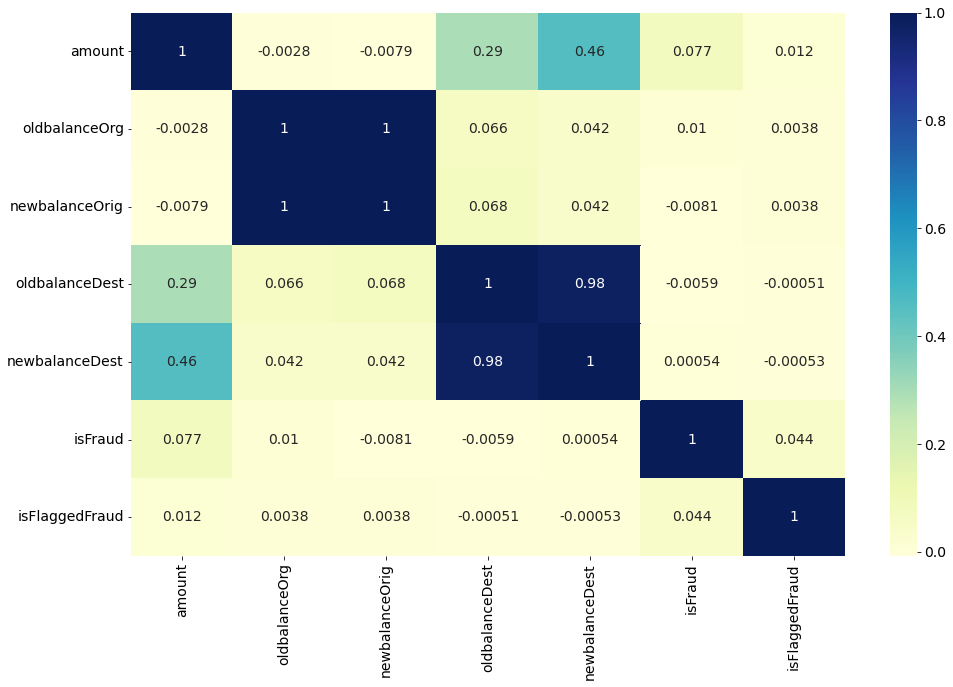

In [24]:
plt.figure(figsize = (16,10))
sns.heatmap(data.corr(), annot = True, cmap = "YlGnBu")
plt.show()

In [25]:
#Feature encoding

for col in data.columns[0:]:
    label = LabelEncoder()
    label.fit(data[col].values)
    data[col] = label.transform(list(data[col].values)).astype(float)


In [26]:
data.head(10)

,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,3.00,"710,400.00","757,869.00","587,897.00","1,157,557.00","1,662,094.00",0.00,0.00,0.00,0.00
1,3.00,"141,767.00","2,188,998.00","140,919.00","336,044.00","1,733,924.00",0.00,0.00,0.00,0.00
2,4.00,"13,666.00","1,002,156.00","1,672.00",0.00,"439,685.00",0.00,0.00,1.00,0.00
3,1.00,"13,666.00","5,828,262.00","1,672.00",0.00,"391,696.00","82,843.00",0.00,1.00,0.00
4,3.00,"822,964.00","3,445,981.00","230,032.00","456,430.00","828,919.00",0.00,0.00,0.00,0.00
5,3.00,"576,823.00","6,026,525.00","276,798.00","599,444.00","2,247,218.00",0.00,0.00,0.00,0.00
6,3.00,"527,683.00","1,805,947.00","613,186.00","1,208,464.00","2,063,363.00",0.00,0.00,0.00,0.00
7,3.00,"579,814.00","2,999,171.00","599,250.00","1,183,430.00","2,314,008.00",0.00,0.00,0.00,0.00
8,3.00,"304,861.00","869,140.00","20,694.00",0.00,"768,940.00",0.00,0.00,0.00,0.00
9,2.00,"401,807.00","5,407,276.00","230,701.00","515,728.00","282,960.00","155,355.00","127,382.00",0.00,0.00


In [27]:
#Create model train and test splits of 80/20 from train dataset.
y = data['isFraud']
x = data.drop(columns = ['isFraud','isFlaggedFraud'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

## Evaluate Accuracy Of ML Models

In [28]:
# Logistic Regression GPU Model
from cuml.linear_model import LogisticRegression as cuLR
cuLG_model = cuLR(max_iter=500)
cuLG_model.fit(x_train, y_train)
cuLG_predictions = cuLG_model.predict(x_test)
print("Accuracy is: " + "{:,.2%}".format(accuracy_score(y_test,cuLG_predictions)))

Accuracy is: 99.93%


In [ ]:
# mini batch SGD GPU Model
from cuml.linear_model import MBSGDClassifier as MBSGD
MBSGD_model = MBSGD()
MBSGD_model.fit(x_train, y_train)
MBSGD_predictions = MBSGD_model.predict(x_test)
print("Accuracy is: " + "{:,.2%}".format(accuracy_score(y_test,MBSGD_predictions)))

In [ ]:
# Stochastic Gradient Descent GPU Model
from cuml.solvers import SGD as cumlSGD
cumlSGD_model = cumlSGD()
cumlSGD_model.fit(x_train, y_train)
cumlSGD_predictions = cumlSGD_model.predict(x_test)
print("Accuracy is: " + "{:,.2%}".format(accuracy_score(y_test,cumlSGD_predictions)))

In [17]:
# Random Forest Model
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, max_depth = 12, random_state = 1)
RF_model.fit(x_train, y_train)
RF_predictions = RF_model.predict(x_test)
print("Accuracy is: " + "{:,.2%}".format(accuracy_score(y_test,RF_predictions)))

Accuracy is: 99.96%


In [19]:
# Single Layer Neural Network
from sklearn.neural_network import MLPClassifier
MLP_model = MLPClassifier(hidden_layer_sizes=(len(x_train.columns),), activation='relu', solver='adam', batch_size='auto', random_state = 1, max_iter=1000) # max_iter = epochs
MLP_model.fit(x_train, y_train)
MLP_predictions = MLP_model.predict(x_test)
print("Accuracy is: " + "{:,.2%}".format(accuracy_score(y_test,MLP_predictions)))

Accuracy is: 99.87%


In [20]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB as GNB
GNB_model = GNB()
GNB_model.fit(x_train, y_train)
GNB_predictions = GNB_model.predict(x_test)
print("Accuracy is: " + "{:,.2%}".format(accuracy_score(y_test,GNB_predictions)))

Accuracy is: 99.87%


In [21]:
# Support Vector Machine
from sklearn.svm import SVC
SVM_model = SVC()
SVM_model.fit(x_train, y_train)
SVM_predictions = SVM_model.predict(x_test)
print("Accuracy is: " + "{:,.2%}".format(accuracy_score(y_test,SVM_predictions)))

Accuracy is: 99.93%


In [22]:
# K Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier as KNN
KNN_model = KNN(n_neighbors = 3) # optimal value of 3
KNN_model.fit(x_train, y_train)
KNN_predictions = KNN_model.predict(x_test)
print("Accuracy is: " + "{:,.2%}".format(accuracy_score(y_test,KNN_predictions)))

Accuracy is: 99.93%


In [23]:
# Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier
GBC_model = GradientBoostingClassifier(n_estimators = 50, learning_rate = 1.0, max_depth = 1, random_state = 1)
GBC_model.fit(x_train, y_train)
GBC_predictions = GBC_model.predict(x_test)
print("Accuracy is: " + "{:,.2%}".format(accuracy_score(y_test,GBC_predictions)))

Accuracy is: 99.87%


In [24]:
# XGBoost
from xgboost import XGBClassifier
XGB_model = XGBClassifier()
XGB_model.fit(x_train, y_train)
XGB_predictions = XGB_model.predict(x_test)
print("Accuracy is: " + "{:,.2%}".format(accuracy_score(y_test,XGB_predictions)))

/home/jc/miniconda3/envs/rapids-22.02/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:07:52] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1643825494080/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy is: 99.97%


## Visualize Feature Importance

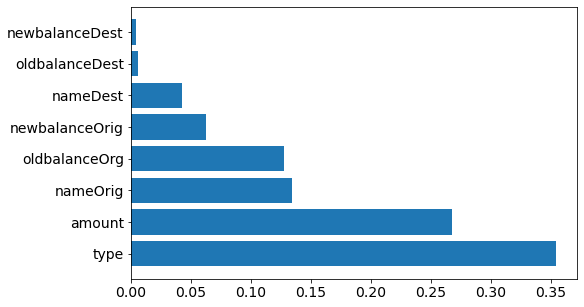

In [18]:
# Using the feature importance attribute of the Random Forest classifier
feature_importance = pd.Series(RF_model.feature_importances_)
feature_importance.index = x_train.columns
feature_importance = feature_importance.sort_values(ascending = False)

# Plot values
plt.figure(figsize = (8,5))
plt.barh(x_train.columns, feature_importance)
plt.show()

In [19]:
# Save Processed Dataset to new csv
data.to_csv("ProcessedData.csv", index=False)